In [314]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import os

os.getcwd()

'C:\\Users\\anscha\\Ecological Modelling course'

In [315]:
class diffusion_advection_plankton_nutrient_detritus_seasonal:
  
     # constructor method
    def __init__(self, alpha, eps, m, u, mu_max, I_0, k, depth, n, time, y, N_b, K_n, K_w, K_c, av, gamma, tau, t, count):
        # object attributes
        self.alpha = alpha
        self.eps = eps
        self.m = m
        self.u = u
        self.mu_max = mu_max
        self.I_0 = I_0
        self.k = k
        
        self.depth = depth
        self.n = n
        self.delta_z = self.depth/self.n
        self.z = np.arange(0.5*self.delta_z, self.depth-0.5*self.delta_z+1, self.delta_z)
        self.time = time
        self.y = y
        self.N_b = N_b 
        
        self.K_n = K_n
        self.K_w = K_w
        self.K_c = K_c
        self.av = av ## previosuly used as D
        self.gamma = gamma
        self.tau = tau
        self.t = t
        self.count = count
        
    def derivative_func(self, time, y):
        
        ######### phytoplankton concentration #############
        omega = y[:self.n]

        dpdt = np.zeros(len(self.z))  # USED FOR PLANKTON
        j_a = np.zeros(len(self.z)+1)
        j_d = np.zeros(len(self.z)+1)
        j = np.zeros(len(self.z)+1)

        for i in range(self.n+1):
            if i == 0 or i == self.n:
                j_a[i] = 0  ### advection is zero at surface and bottom
                j_d[i] = 0 ### diffusion is zero at surface and bottom
            else:
                j_a[i] = self.u*omega[i-1]
                j_d[i] = -self.av*(omega[i] - omega[i-1])/self.delta_z

            j[i] = j_a[i] + j_d[i]

        for i in range(self.n):
            dpdt[i] = (j[i+1]-j[i])/self.delta_z
        
        ######### nutrient #############
        N = y[self.n:self.n*2]

        dNdt = np.zeros(len(self.z))  # USED FOR nutrient
        #j_a = np.zeros(len(self.z)+1)
        j_d = np.zeros(len(self.z)+1)
        j = np.zeros(len(self.z)+1)

        for i in range(self.n+1):
            if i == 0:
                j_d[i] = 0 ### diffusion is zero at surface and bottom
            
            elif i == self.n:
                j_d[i] = -self.av*(N_b - N[i-1])/self.delta_z
            else:
                j_d[i] = -self.av*(N[i] - N[i-1])/self.delta_z
                
            j[i] = j_d[i] # + j_a[i] ### advection for nutrients in always zero

        for i in range(self.n):
            dNdt[i] = -(j[i+1]-j[i])/self.delta_z
            
        ######### Detritus #############
        D = y[self.n*2:]

        dDdt = np.zeros(len(self.z))  # USED FOR PLANKTON
        j_a = np.zeros(len(self.z)+1)
        j_d = np.zeros(len(self.z)+1)
        j = np.zeros(len(self.z)+1)

        for i in range(self.n+1):
            if i == 0 or i == self.n:
                j_a[i] = 0  ### advection is zero at surface and bottom
                j_d[i] = 0 ### diffusion is zero at surface and bottom
            else:
                j_a[i] = self.u*D[i-1]
                j_d[i] = -self.av*(D[i] - D[i-1])/self.delta_z

            j[i] = j_a[i] + j_d[i]

        for i in range(self.n):
            dDdt[i] = -(j[i+1]-j[i])/self.delta_z
        
        return np.concatenate((dpdt, dNdt, dDdt), axis=None)
    
    def calc_intensity(self, y):
        omega = y[:self.n]
        
        if self.count < self.time[1]:
            val = (1-np.cos((2*3.14*self.t[self.count])/self.time[1]))
            
        else:
            self.count = 0
            val = (1-np.cos((2*3.14*self.t[self.count])/self.time[1]))
        
        self.count += 1
        intensity = np.cumsum((omega + D) * self.delta_z) * self.k
        return self.I_0*val*np.exp((self.K_w + self.K_c*intensity)*-self.z)  ###D is detrius coefficient  and negative z for decreasing depth
    
    def growth_limit(self, y):
        N = y[self.n:self.n*2]
        sigma_N = (N/(self.K_n + N))
        sigma_L = self.alpha*self.calc_intensity(y)/(np.sqrt(self.mu_max**2 + (self.alpha**2)*(self.calc_intensity(y)**2)))
        return sigma_N, sigma_L
    
    def update(self, time, y):
        sigma_N, sigma_L = self.growth_limit(y)
        omega = y[:self.n]
        D  = y[self.n*2:]
        change_conc = self.derivative_func(time, y)
        g_p = change_conc[:self.n] + (self.mu_max*sigma_L*sigma_N*omega) - (self.eps*omega) - (self.gamma*omega**2)
        g_n = change_conc[self.n:self.n*2] - (self.mu_max*sigma_L*sigma_N*omega) + (self.tau*D)
        g_d = change_conc[self.n*2:] + (self.eps*omega) + (self.gamma*omega**2) - (self.tau*D)
        return np.concatenate((g_p, g_n, g_d), axis=None)
    
    def solver(self):
        method = 'RK45' #available methods: 'RK45', 'RK23', 'DOP853', 'Radau', 'BDF', 'LSODA'
        solver_output = solve_ivp(self.update, self.time, self.y, method=method, dense_output=True)
        new_time = solver_output.t
        output = solver_output.y
        return new_time, output

In [305]:
depth = 200
n = 20
delta_z = depth/n
z = np.arange(0.5*delta_z, depth-0.5*delta_z+1, delta_z)
omega = np.ones(n)*10**0.01  ## intial concentration value
N = np.ones(n)*5.0 ## intial Nutrient value
D = np.zeros(n)
y = np.zeros(n*3)
y[:n] = omega
y[n:n*2] = N
y[n*2:] = D

time_begin = 0
time_end = 300
time = [time_begin,time_end]

#### lecture three parameters
alpha = 0.1 #10**(-9) ### nutrient content of phytoplankton
eps = 0.03 #0.5 ## phytoplankton recycling coefficient
m = 0.01
u = 0.04 ## sinking velocity (v)
av = 0.00005 ## depth dependent turbulent diffusivity (previosuly used as D(z))
#H_n = 0.0425 ## 0.015 ## H_n is half saturation constants for nutrient 
#H_i = 20.0 ## 98 ## H_i is half saturation constant for intensity
mu_max = 0.5 ## mu_max is max growth rate
I_0 = 200 ## I_0 is the incident light intensity (on the surface of ocean)
#k_bg = 0.2 ## turbidity of the water without biomass
k = 15*10**(-12) #k is the phytoplankton light absorption coefficient
N_b = 50 ## (5 to 100) Nutrient concentration at bottom

#### Lecture four parameters
K_n = 0.3 ### half-saturation constant
K_w = 0.0375 ### attenuation coefficient of water
K_c = 0.05 ### self shading coefficient
gamma = 1.5 ## zooplankton quadratic grazing parameter
tau = 0.1 ### 
t = np.arange(0,time_end) ## add seasonality
count = 0

In [306]:
object1 = diffusion_advection_plankton_nutrient_detritus_seasonal(alpha, eps, m, u, mu_max, I_0, k, depth, n, time, y, N_b, K_n, K_w, K_c, av, gamma, tau, t, count)
new_time, output = object1.solver()

C:\Users\anscha\AppData\Local\Temp/ipykernel_22468/3111698513.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(list(z[::-1]))
C:\Users\anscha\AppData\Local\Temp/ipykernel_22468/3111698513.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(list(z[::-1][::2]))


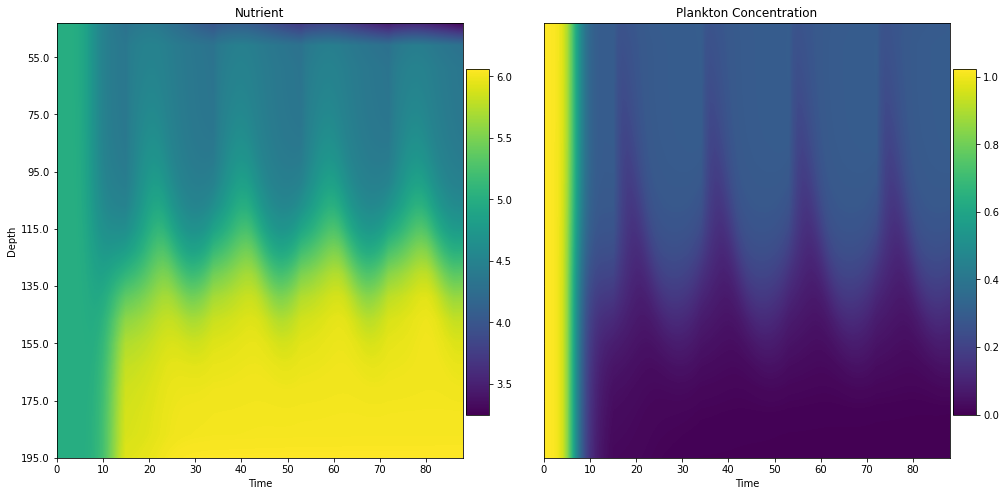

In [308]:
### contour plot

plankton_conc = output[:n]
nutrient = output[n:n*2]
import matplotlib as mpl
fig = plt.figure(figsize=(16, 8))
gs = mpl.gridspec.GridSpec(1, 2, height_ratios=[1], width_ratios=[1, 1])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 0], sharex=ax1)

X = np.arange(plankton_conc.T.shape[0])
Y = np.arange(plankton_conc.T.shape[1])
X, Y = np.meshgrid(X, Y)
Z = plankton_conc[::-1] ## reverse for plotting
vmin = np.min(Z)
vmax = np.max(Z)
cont1 = ax1.contourf(X, Y, Z, 400, vmin=vmin, vmax=vmax)
ax1.set_xlabel('Time')
ax1.set_title('Plankton Concentration')
ax1.set_yticklabels(list(z[::-1]))
ax1.tick_params(axis='y', colors = 'w')
cax = fig.add_axes([0.903, 0.2, 0.02, 0.6])
fig.colorbar(
   plt.cm.ScalarMappable(norm=cont1.norm, cmap=cont1.cmap), cax
)

X = np.arange(nutrient.T.shape[0])
Y = np.arange(nutrient.T.shape[1])
X, Y = np.meshgrid(X, Y)
Z = nutrient[::-1]
vmin = np.min(Z)
vmax = np.max(Z)
cont2 = ax2.contourf(X, Y, Z, 400, vmin=vmin, vmax=vmax)
ax2.set_xlabel('Time')
ax2.set_ylabel('Depth')
ax2.set_title('Nutrient')
ax2.set_yticklabels(list(z[::-1][::2]))
cax = fig.add_axes([0.48, 0.2, 0.02, 0.6])
fig.colorbar(
   plt.cm.ScalarMappable(norm=cont2.norm, cmap=cont2.cmap), cax
)
plt.savefig('C:/Users/anscha/Ecological Modelling course/reference_model/seasonal_ref.png')

In [309]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

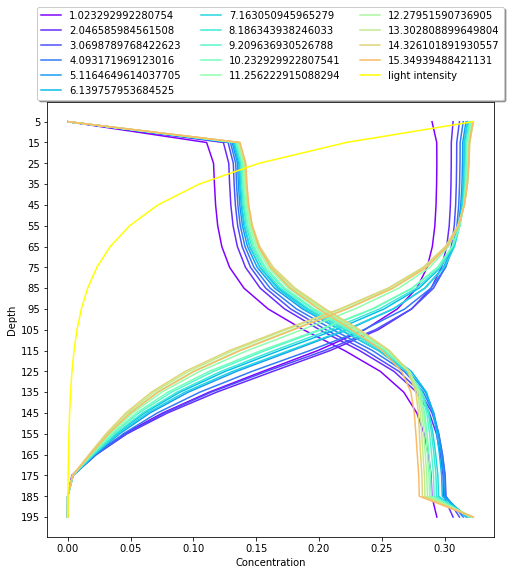

In [313]:
from matplotlib import cm
omega = np.ones(n)  ## intial concentration value
N = np.ones(n) ## intial Nutrient value
D = np.zeros(n)
fig, ax = plt.subplots(figsize = (8,8))
n_conc = 15
color=iter(cm.rainbow(np.linspace(0,1,n)))
for i in range(n_conc):
    c=next(color)
    
    y[:n] = omega*10**0.01*(i+1)
    y[n:n*2] = N*5.0*(i+1)
    y[n*2:] = D
    object1 = diffusion_advection_plankton_nutrient_detritus_seasonal(alpha, eps, m, u, mu_max, I_0, k, depth, n, time, y, N_b, K_n, K_w, K_c, av, gamma, tau, t, count)
    new_time, output = object1.solver()
    plankton_conc = output[:n]
    nutrient_conc = output[n:n*2]
    ax.plot(plankton_conc[:,-1], z, label = f'{y[:n][0]}', c=c)
    b = scaler.fit_transform(nutrient_conc[:,-1].reshape(-1,1))*np.max(plankton_conc[:,-1])
    ax.plot(b.ravel(), z, c=c)
    ax.set_yticks(list(z))
    ax.invert_yaxis()
a = scaler.fit_transform(object1.calc_intensity(output[:n,-1]).reshape(-1,1))*np.max(plankton_conc[:,-1])
plt.plot(a.ravel(), z, color = 'yellow', label = 'light intensity')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.23),
          ncol=3, fancybox=True, shadow=True)
#plt.legend(fancybox=True, framealpha=0.5, bbox_to_anchor=(1, 0.50))
plt.xlabel('Concentration')
plt.ylabel('Depth')
plt.savefig('C:/Users/anscha/Ecological Modelling course/reference_model/ref_model_2.png')
plt.show()